## Problem Overview
The goal is to predict the truth ratings that human fact checkers would assign to each
claim in the dataset based on some related articles and the metadata associated with each claim.

## Data
The dataset contains claims and the associated metadata from 9 fact checking
websites. On those
websites, professional fact checkers publish a truth rating for each claim with links to the related articles. The truth ratings provided were mapped to the labels:
-  0 (false)
-  1 (partly true) 
- 2 (true)

## Approach

In this notebook, I've implemented the following approach.

First, the claim and the related articles are preprocessed by converting each
sentence into a TF-IDF representation. The 5 sentences that have the highest cosine
similarity with a claim are extracted and concatenated with the metadata. 

Then,
Bi-directional Encoder Representations from Transformers (BERT) is fine-tuned
based on these sentences and the metadata to predict the label of each claim.

## Setup

In [1]:
!pip install gdown

In [2]:
!gdown --id 1Hxk35b28q85y2HrtE1V_We_WlcMaOd25

Downloading...
From: https://drive.google.com/uc?id=1Hxk35b28q85y2HrtE1V_We_WlcMaOd25
To: /content/leadersboard2019.zip
195MB [00:01, 119MB/s]


In [3]:
!ls

drive  leadersboard2019.zip  sample_data  train_articles  train.json


In [4]:
!unzip leadersboard2019.zip

Archive:  leadersboard2019.zip
replace train.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
!pip install transformers

In [6]:
import json
import numpy as np
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def preprocess_articles():
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
  
        if id % 500 == 0:
            print("Claims preprocessed: ",id)
        
        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)
    
        # measure similarity between claim and each sentence
        similarity =  X[-1,:] @ np.transpose(X[:-2,:])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1,min(5,sorted_index.shape[1])+1):
            top_sentences.append(sentences[sorted_index[0,-i]])
        relevant_sentences.append(top_sentences)

   
    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
n_claims = len(metadata)
print('Number of claims: {:,}\n'.format(n_claims))
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])

Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Number of claims: 15,555

Metadata of claim 0:
A line from George Orwell's novel 1984 predicts the power of smartphones.
Relevan

In [0]:
import pandas as pd
from pandas.io.json import json_normalize

df = pd.DataFrame.from_dict(json_normalize(metadata), orient='columns')
df["relevant_sentences"] = np.asarray(relevant_sentences)

In [9]:
df.sample(5)

,claim,claimant,date,label,related_articles,id,relevant_sentences
12078,"In early January 2019, all speed cameras on th...",,2019-01-10,0,"[105108, 133664, 133665, 148710]",13308,"[\nFrank Sinclair on Twitter: ""All cameras on ..."
8439,A photograph depicts a sign on a unisex Kroger...,,2016-03-31,2,"[120047, 136261, 136617]",9308,"[— Ramblin' Man (@RamblinManNC) March 29, 2016..."
13276,“No letter [from Yanukovych in 2014] was offic...,Dmitry Peskov,2017-03-20,1,"[134194, 133030, 151420, 124306, 111981, 122623]",14628,"[""No letter was officially submitted to the Ru..."
11793,"American liberals are debating the merits of ""...",,2018-10-12,1,"[107062, 109289, 109733, 126062, 126322, 12645...",12988,[Adoption as an alternative to after-birth abo...
2217,Tiger Woods named his restaurant “The Woods Ju...,,2015-03-13,0,"[119090, 119091]",2447,"[“Tiger owns his own name and always had., The..."


In [10]:
df.loc[0]

claim                 A line from George Orwell's novel 1984 predict...
claimant                                                               
date                                                         2017-07-17
label                                                                 0
related_articles                       [122094, 122580, 130685, 134765]
id                                                                    0
relevant_sentences    [1984 by George Orwell\n1984 is a dystopian no...
Name: 0, dtype: object

In [11]:
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from transformers import BertForSequenceClassification, AdamW, BertConfig

## Tokenize

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
all_input_ids = []
all_attention_masks = []
all_token_type_ids = []
all_labels = []
all_features = []
data_len = df.shape[0]
for i in range(data_len):
  claim = df.loc[i].claim
  text = " ".join(df.loc[i].relevant_sentences)
  label = df.loc[i].label
  
  features = tokenizer.encode_plus(claim, text, add_special_tokens=True, max_length=512, pad_to_max_length=True, return_tensors='pt')
  all_features.append(features)
  all_input_ids.append(features['input_ids'].flatten())
  all_attention_masks.append(features['attention_mask'].flatten())
  all_token_type_ids.append(features['token_type_ids'].flatten())
  all_labels.append(label)

## Train-Test Split

In [14]:
SPLIT = 10000
train_input_ids_tensor = torch.stack(all_input_ids[:SPLIT]).long()
train_attention_masks = torch.stack(all_attention_masks[:SPLIT]).long()
train_token_type_ids = torch.stack(all_token_type_ids[:SPLIT]).long()
train_labels = torch.tensor(torch.tensor(all_labels[:SPLIT]).reshape(-1,1), dtype=torch.long)

test_input_ids_tensor = torch.stack(all_input_ids[SPLIT:]).long()
test_attention_masks = torch.stack(all_attention_masks[SPLIT:]).long()
test_token_type_ids = torch.stack(all_token_type_ids[SPLIT:]).long()
test_labels = torch.tensor(torch.tensor(all_labels[SPLIT:]).reshape(-1,1), dtype=torch.long).reshape(-1, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [0]:
BATCH_SIZE = 12
EPOCHS = 4

In [0]:
train_dataset = TensorDataset(train_input_ids_tensor, train_attention_masks, train_token_type_ids, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids_tensor, test_attention_masks, test_token_type_ids, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

## Fine-Tune BERT For Sequence Classification

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [19]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
torch.cuda.empty_cache()
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.071232M'

In [0]:
optimizer = Adam(model.parameters(), lr=3e-6)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Training

In [23]:
loss_values = []
for epoch_num in range(EPOCHS):
    print('======== Epoch {:} / {:} ========'.format(epoch_num + 1, EPOCHS))
    t0 = time.time()
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        input_ids, attn_masks, token_type_ids, labels = tuple(t.to(device) for t in batch_data)
        model.zero_grad()  
        outputs = model(input_ids, 
                    token_type_ids=token_type_ids, 
                    attention_mask=attn_masks,
                    labels=labels)
        loss = outputs[0]
        train_loss += loss.item()
        loss.backward()
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_dataloader)                
    loss_values.append(avg_train_loss)
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epcoh took: {:}".format(format_time(time.time() - t0)))
    print("")

======== Epoch 1 / 4 ========
Average training loss: 0.91
Training epcoh took: 0:18:13

======== Epoch 2 / 4 ========
Average training loss: 0.84
Training epcoh took: 0:18:22

======== Epoch 3 / 4 ========
Average training loss: 0.79
Training epcoh took: 0:18:22

======== Epoch 4 / 4 ========
Average training loss: 0.74
Training epcoh took: 0:18:21



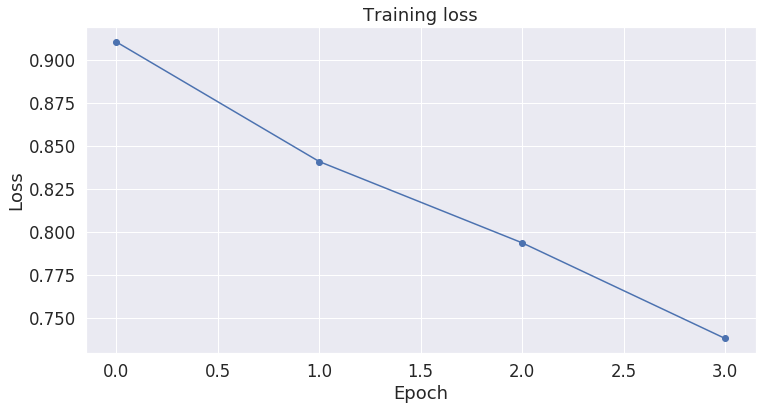

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Evaluation

In [0]:
# Prediction on test set
model.eval()
predictions, true_labels = [], []
bert_predicted = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        b_input_ids, b_attn_masks, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch_data)

        outputs = model(b_input_ids, token_type_ids=b_token_type_ids, 
                      attention_mask=b_attn_masks)
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

        # The predictions for this batch are a 3-column ndarray (one column for "0",
        # one column for "1", one column for "2"). Pick the label with the highest value and turn this
        # in to a list of 0s and 1s.
        pred_labels_i = np.argmax(logits, axis=1).flatten()
        bert_predicted.extend(pred_labels_i)

In [26]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, bert_predicted))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      2621
           1       0.60      0.73      0.66      2355
           2       0.30      0.01      0.02       579

    accuracy                           0.64      5555
   macro avg       0.53      0.48      0.46      5555
weighted avg       0.61      0.64      0.61      5555

